#📌 Extracción

In [40]:
import requests
import pandas as pd

# URL de la API
api_url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"

try:
    # Realizar la solicitud GET a la API
    response = requests.get(api_url)
    response.raise_for_status()  # Lanzar un error para códigos de estado HTTP erróneos (4xx o 5xx)

    # Cargar los datos JSON
    data = response.json()

    # Convertir los datos a un DataFrame de pandas
    df_telecom = pd.DataFrame(data)

    print("Datos importados exitosamente.")
    print(f"Dimensiones del DataFrame: {df_telecom.shape}")
    print("Primeras 5 filas del DataFrame:")
    print(df_telecom.head())

except requests.exceptions.RequestException as e:
    print(f"Error al conectar con la API: {e}")
except ValueError as e:
    print(f"Error al decodificar JSON: {e}")
except Exception as e:
    print(f"Ocurrió un error inesperado: {e}")




Datos importados exitosamente.
Dimensiones del DataFrame: (7267, 6)
Primeras 5 filas del DataFrame:
   customerID Churn                                           customer  \
0  0002-ORFBO    No  {'gender': 'Female', 'SeniorCitizen': 0, 'Part...   
1  0003-MKNFE    No  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
2  0004-TLHLJ   Yes  {'gender': 'Male', 'SeniorCitizen': 0, 'Partne...   
3  0011-IGKFF   Yes  {'gender': 'Male', 'SeniorCitizen': 1, 'Partne...   
4  0013-EXCHZ   Yes  {'gender': 'Female', 'SeniorCitizen': 1, 'Part...   

                                             phone  \
0   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
1  {'PhoneService': 'Yes', 'MultipleLines': 'Yes'}   
2   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
3   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   
4   {'PhoneService': 'Yes', 'MultipleLines': 'No'}   

                                            internet  \
0  {'InternetService': 'DSL', 'OnlineSecurity': '...   
1  {'InternetServi

#🔧 Transformación

Comprobación de incoherencias en los datos

In [41]:
print("Información del DataFrame df_telecom:")
df_telecom.info()

Información del DataFrame df_telecom:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   customerID  7267 non-null   object
 1   Churn       7267 non-null   object
 2   customer    7267 non-null   object
 3   phone       7267 non-null   object
 4   internet    7267 non-null   object
 5   account     7267 non-null   object
dtypes: object(6)
memory usage: 340.8+ KB


In [42]:
null_values = df_telecom.isnull().sum()
print("Número de valores nulos por columna:")
print(null_values)

Número de valores nulos por columna:
customerID    0
Churn         0
customer      0
phone         0
internet      0
account       0
dtype: int64


In [43]:
duplicate_rows = df_telecom['customerID'].duplicated().sum()
print(f"Número de filas duplicadas en customerID: {duplicate_rows}")

Número de filas duplicadas en customerID: 0


In [44]:
print("Valores únicos y recuentos para la columna 'Churn':")
print(df_telecom['Churn'].value_counts())

Valores únicos y recuentos para la columna 'Churn':
Churn
No     5174
Yes    1869
        224
Name: count, dtype: int64



Manejo de inconsistencias

In [45]:
nested_columns = ['customer', 'phone', 'internet', 'account']
flattened_dfs = []

for col_name in nested_columns:
    # Flatten the nested column
    flattened_df = pd.json_normalize(df_telecom[col_name])

    # Rename columns with a prefix
    renamed_columns = {col: f'{col_name}_{col}' for col in flattened_df.columns}
    flattened_df = flattened_df.rename(columns=renamed_columns)

    flattened_dfs.append(flattened_df)

# Concatenate all flattened DataFrames horizontally
df_flattened = pd.concat(flattened_dfs, axis=1)

# Drop the original nested columns from df_telecom
df_telecom = df_telecom.drop(columns=nested_columns)

# Combine df_telecom with the flattened DataFrame
df_telecom = pd.concat([df_telecom, df_flattened], axis=1)

print("Columnas anidadas aplanadas y añadidas al DataFrame principal.")
print(f"Nuevas dimensiones del DataFrame: {df_telecom.shape}")
print("Primeras 5 filas del DataFrame aplanado:")
print(df_telecom.head())

Columnas anidadas aplanadas y añadidas al DataFrame principal.
Nuevas dimensiones del DataFrame: (7267, 21)
Primeras 5 filas del DataFrame aplanado:
   customerID Churn customer_gender  customer_SeniorCitizen customer_Partner  \
0  0002-ORFBO    No          Female                       0              Yes   
1  0003-MKNFE    No            Male                       0               No   
2  0004-TLHLJ   Yes            Male                       0               No   
3  0011-IGKFF   Yes            Male                       1              Yes   
4  0013-EXCHZ   Yes          Female                       1              Yes   

  customer_Dependents  customer_tenure phone_PhoneService phone_MultipleLines  \
0                 Yes                9                Yes                  No   
1                  No                9                Yes                 Yes   
2                  No                4                Yes                  No   
3                  No               13        

In [46]:
df_telecom['account_Charges.Total'] = pd.to_numeric(df_telecom['account_Charges.Total'], errors='coerce')
median_total_charges = df_telecom['account_Charges.Total'].median()
df_telecom['account_Charges.Total'].fillna(median_total_charges, inplace=True)

print("Columna 'account_Charges.Total' convertida a numérico y valores nulos rellenados con la mediana.")
print(f"Tipo de datos de 'account_Charges.Total': {df_telecom['account_Charges.Total'].dtype}")
print(f"Valores nulos en 'account_Charges.Total' después del procesamiento: {df_telecom['account_Charges.Total'].isnull().sum()}")
print(f"Mediana utilizada para rellenar: {median_total_charges}")


Columna 'account_Charges.Total' convertida a numérico y valores nulos rellenados con la mediana.
Tipo de datos de 'account_Charges.Total': float64
Valores nulos en 'account_Charges.Total' después del procesamiento: 0
Mediana utilizada para rellenar: 1391.0


/tmp/ipython-input-1236515071.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_telecom['account_Charges.Total'].fillna(median_total_charges, inplace=True)


In [47]:
df_telecom['account_Charges.Total'] = pd.to_numeric(df_telecom['account_Charges.Total'], errors='coerce')
median_total_charges = df_telecom['account_Charges.Total'].median()
df_telecom['account_Charges.Total'] = df_telecom['account_Charges.Total'].fillna(median_total_charges)

print("Columna 'account_Charges.Total' convertida a numérico y valores nulos rellenados con la mediana.")
print(f"Tipo de datos de 'account_Charges.Total': {df_telecom['account_Charges.Total'].dtype}")
print(f"Valores nulos en 'account_Charges.Total' después del procesamiento: {df_telecom['account_Charges.Total'].isnull().sum()}")
print(f"Mediana utilizada para rellenar: {median_total_charges}")

Columna 'account_Charges.Total' convertida a numérico y valores nulos rellenados con la mediana.
Tipo de datos de 'account_Charges.Total': float64
Valores nulos en 'account_Charges.Total' después del procesamiento: 0
Mediana utilizada para rellenar: 1391.0


In [48]:
initial_rows = df_telecom.shape[0]
df_telecom = df_telecom[df_telecom['Churn'] != '']
final_rows = df_telecom.shape[0]

print(f"Filas eliminadas con valores vacíos en 'Churn': {initial_rows - final_rows}")
print(f"Nuevas dimensiones del DataFrame después de eliminar filas con 'Churn' vacío: {df_telecom.shape}")
print("Valores únicos y recuentos para la columna 'Churn' después de la limpieza:")
print(df_telecom['Churn'].value_counts())

Filas eliminadas con valores vacíos en 'Churn': 224
Nuevas dimensiones del DataFrame después de eliminar filas con 'Churn' vacío: (7043, 21)
Valores únicos y recuentos para la columna 'Churn' después de la limpieza:
Churn
No     5174
Yes    1869
Name: count, dtype: int64


In [49]:
print("Información del DataFrame df_telecom (tipos de datos):\n")
df_telecom.info()

Información del DataFrame df_telecom (tipos de datos):

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customerID                 7043 non-null   object 
 1   Churn                      7043 non-null   object 
 2   customer_gender            7043 non-null   object 
 3   customer_SeniorCitizen     7043 non-null   int64  
 4   customer_Partner           7043 non-null   object 
 5   customer_Dependents        7043 non-null   object 
 6   customer_tenure            7043 non-null   int64  
 7   phone_PhoneService         7043 non-null   object 
 8   phone_MultipleLines        7043 non-null   object 
 9   internet_InternetService   7043 non-null   object 
 10  internet_OnlineSecurity    7043 non-null   object 
 11  internet_OnlineBackup      7043 non-null   object 
 12  internet_DeviceProtection  7043 non-null   object 
 1

#📊 Carga y análisis

Análisis Descriptivo

In [50]:
print("Revisando valores únicos para columnas de tipo 'object':\n")
for column in df_telecom.select_dtypes(include='object').columns:
    print(f"Columna '{column}':")
    print(df_telecom[column].value_counts())
    print("\n")

print("Revisando estadísticas descriptivas para columnas numéricas:\n")
print(df_telecom.select_dtypes(include=['int64', 'float64']).describe())

Revisando valores únicos para columnas de tipo 'object':

Columna 'customerID':
customerID
9995-HOTOH    1
0002-ORFBO    1
0003-MKNFE    1
9970-QBCDA    1
9968-FFVVH    1
             ..
0014-BMAQU    1
0013-SMEOE    1
0013-MHZWF    1
0013-EXCHZ    1
0011-IGKFF    1
Name: count, Length: 7043, dtype: int64


Columna 'Churn':
Churn
No     5174
Yes    1869
Name: count, dtype: int64


Columna 'customer_gender':
customer_gender
Male      3555
Female    3488
Name: count, dtype: int64


Columna 'customer_Partner':
customer_Partner
No     3641
Yes    3402
Name: count, dtype: int64


Columna 'customer_Dependents':
customer_Dependents
No     4933
Yes    2110
Name: count, dtype: int64


Columna 'phone_PhoneService':
phone_PhoneService
Yes    6361
No      682
Name: count, dtype: int64


Columna 'phone_MultipleLines':
phone_MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64


Columna 'internet_InternetService':
internet_InternetService

Distribución de evasión

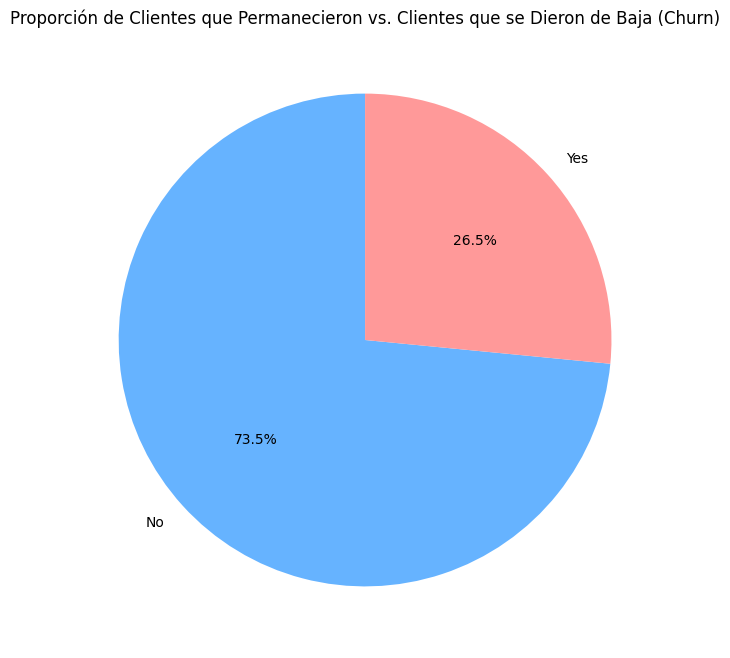

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the churn distribution
churn_counts = df_telecom['Churn'].value_counts()
churn_percentages = churn_counts / len(df_telecom) * 100

# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(churn_percentages, labels=churn_percentages.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
plt.title('Proporción de Clientes que Permanecieron vs. Clientes que se Dieron de Baja (Churn)')
plt.ylabel('') # Remove default 'y' label
plt.show()


Recuento de evasión por variables categóricas

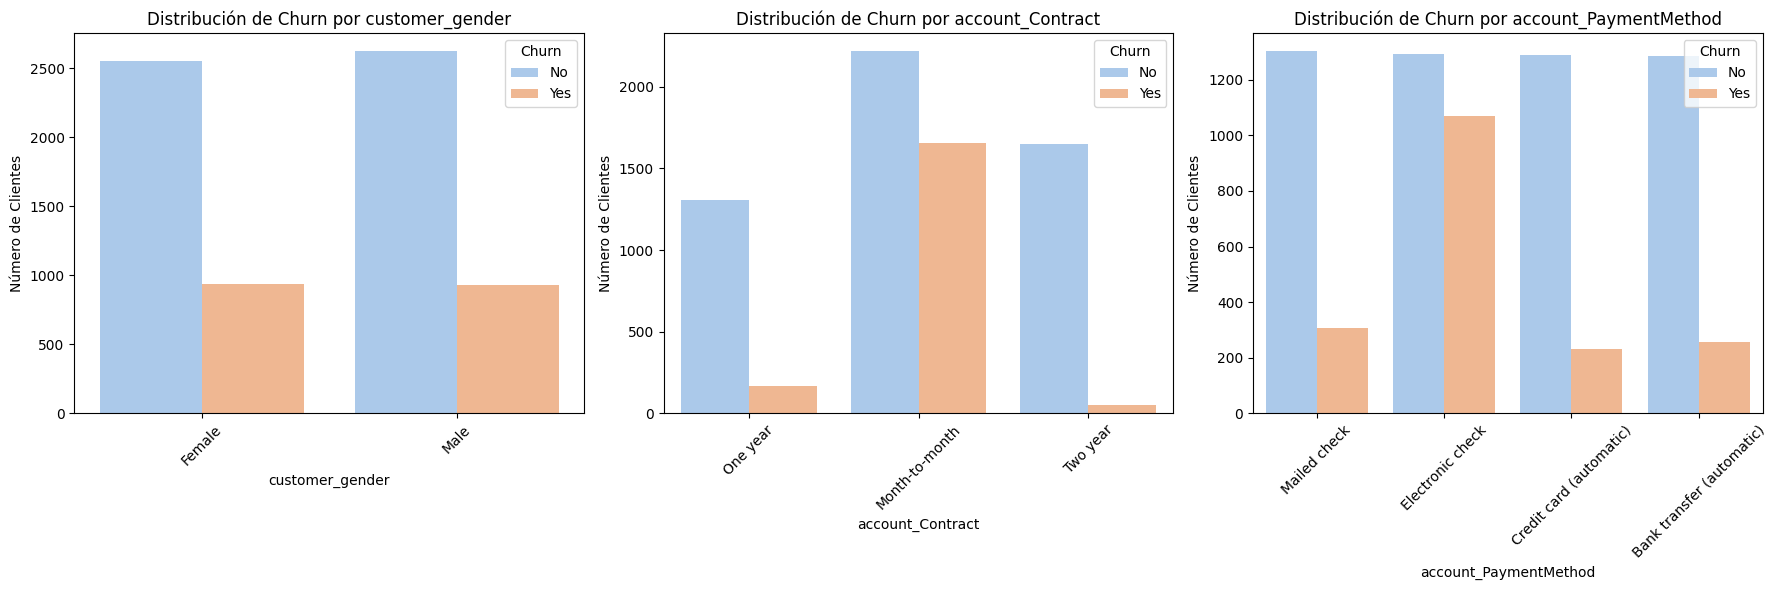

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

categorical_cols = ['customer_gender', 'account_Contract', 'account_PaymentMethod']

fig, axes = plt.subplots(1, len(categorical_cols), figsize=(18, 6), sharey=False)
axes = axes.flatten() # Ensure axes is an array for easy iteration

for i, col in enumerate(categorical_cols):
    sns.countplot(data=df_telecom, x=col, hue='Churn', ax=axes[i], palette='pastel')
    axes[i].set_title(f'Distribución de Churn por {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Número de Clientes')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].legend(title='Churn')

plt.tight_layout()
plt.show()

Conteo de evasión por variables numéricas

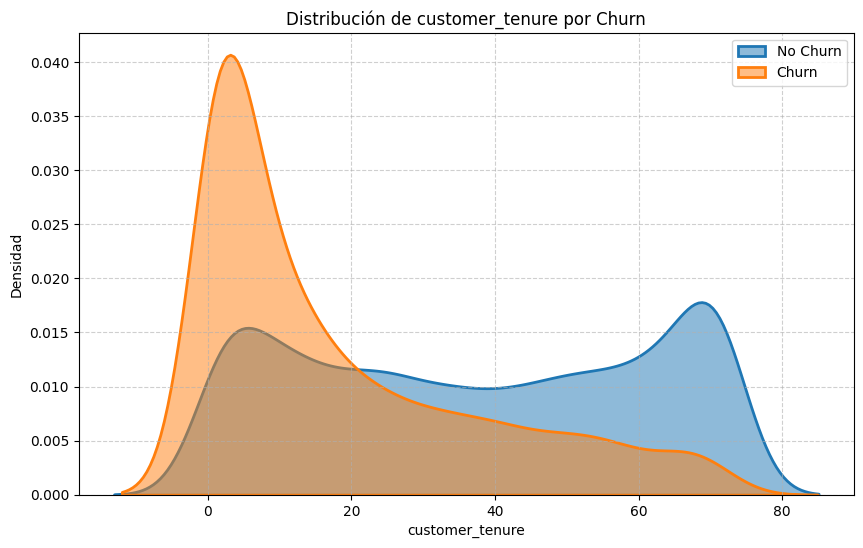

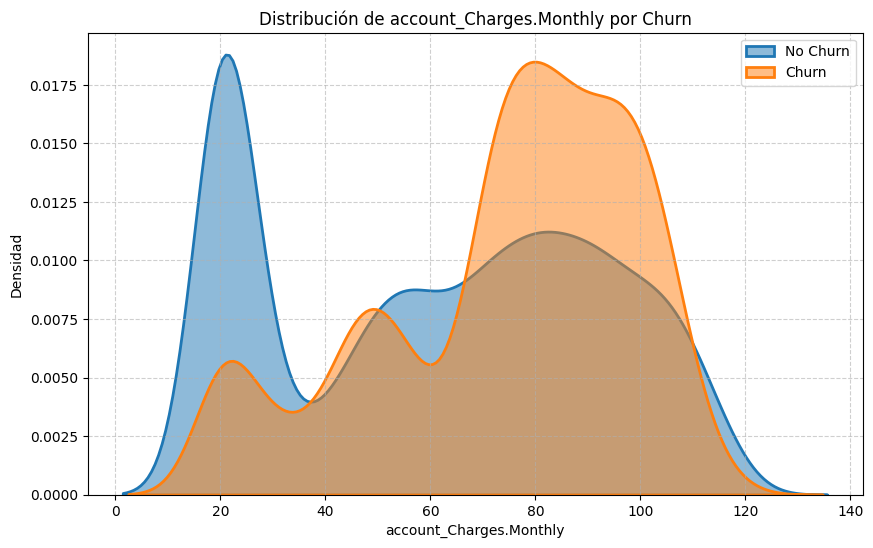

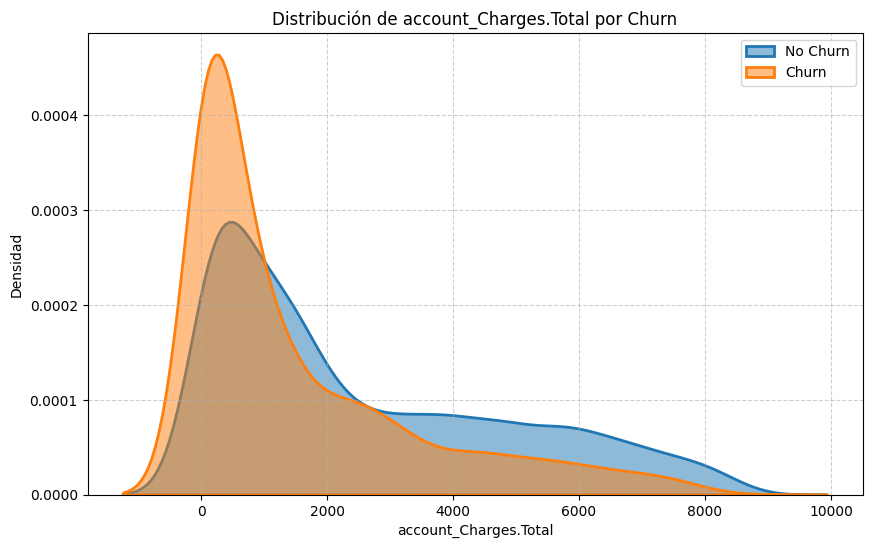

In [53]:
numerical_cols = ['customer_tenure', 'account_Charges.Monthly', 'account_Charges.Total']

for col in numerical_cols:
    plt.figure(figsize=(10, 6))
    sns.kdeplot(df_telecom[df_telecom['Churn'] == 'No'][col], label='No Churn', fill=True, alpha=0.5, linewidth=2)
    sns.kdeplot(df_telecom[df_telecom['Churn'] == 'Yes'][col], label='Churn', fill=True, alpha=0.5, linewidth=2)
    plt.title(f'Distribución de {col} por Churn')
    plt.xlabel(col)
    plt.ylabel('Densidad')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

#📄Informe final

## Introducción al Análisis de Churn

El fenómeno de la "Churn" o evasión de clientes, donde los suscriptores deciden finalizar su relación con un proveedor de servicios, representa uno de los desafíos más críticos para las empresas de telecomunicaciones. La pérdida de clientes no solo impacta directamente en los ingresos y la cuota de mercado, sino que también implica costos significativos asociados con la adquisición de nuevos clientes para reemplazar a los perdidos.

El objetivo principal de este análisis es explorar los factores que contribuyen a la evasión de clientes en nuestra empresa de telecomunicaciones. A través de la extracción, transformación y carga de datos relevantes, buscaremos identificar patrones, comportamientos y características distintivas entre los clientes que permanecen y aquellos que se dan de baja. Al comprender mejor las causas subyacentes del churn, podremos desarrollar estrategias de retención más efectivas, personalizar ofertas y servicios, y, en última instancia, mejorar la lealtad de los clientes y la rentabilidad general de la empresa.

## Análisis Exploratorio de Datos y Patrones Identificados

### Resumen de la Inspección Inicial de Datos

Al inicio del análisis, se importaron los datos de la API en un DataFrame de Pandas, `df_telecom`, con 7267 filas y 6 columnas anidadas. Se realizaron las siguientes comprobaciones y limpiezas:

*   **Tipos de Datos y Valores Nulos**: La inspección inicial reveló que todas las columnas eran de tipo 'object' y no se encontraron valores nulos explícitos en las columnas principales, aunque las columnas anidadas requerían un aplanamiento.
*   **Duplicados**: No se encontraron duplicados en la columna `customerID`, lo que asegura la unicidad de los clientes.
*   **Inconsistencias en 'Churn'**: Se identificaron 224 filas con un valor vacío en la columna `Churn`. Estas filas fueron eliminadas para asegurar la calidad del conjunto de datos para el análisis de evasión, resultando en un DataFrame final con 7043 entradas.
*   **Aplanamiento de Columnas Anidadas**: Las columnas anidadas (`customer`, `phone`, `internet`, `account`) se aplanaron exitosamente, expandiendo el DataFrame a 21 columnas y extrayendo detalles importantes de los servicios y cuentas de los clientes.
*   **Manejo de 'account_Charges.Total'**: La columna `account_Charges.Total` se convirtió a tipo numérico y los valores no numéricos se trataron como nulos y se rellenaron con la mediana, asegurando que esta variable fuera utilizable para análisis cuantitativos.

### Observaciones Clave de los Análisis Descriptivos y Univariados

Después de la preparación de los datos, se obtuvieron las siguientes observaciones:

*   **Distribución de 'Churn'**: El conjunto de datos muestra un desbalance significativo, con aproximadamente **73.5%** de clientes que **no** se dan de baja y **26.5%** que **sí** lo hacen. Esto indica que la mayoría de los clientes permanecen, pero un cuarto de ellos se va.
*   **Variables Categóricas**:
    *   **customer_gender**: La distribución de churn es bastante equilibrada entre hombres y mujeres, lo que sugiere que el género no es un factor determinante en la evasión.
    *   **account_Contract**: Los clientes con contratos de `Month-to-month` tienen una tasa de churn significativamente más alta en comparación con aquellos con contratos de `One year` o `Two year`. Los contratos a largo plazo parecen ser un fuerte indicador de lealtad.
    *   **account_PaymentMethod**: Los clientes que utilizan `Electronic check` como método de pago muestran una mayor propensión al churn en comparación con otros métodos como `Mailed check`, `Bank transfer (automatic)` o `Credit card (automatic)`.
*   **Variables Numéricas**:
    *   **customer_SeniorCitizen**: El 16.2% de los clientes son personas mayores, lo cual es un factor a considerar en el análisis.
    *   **customer_tenure**: La antigüedad promedio de los clientes es de aproximadamente 32 meses. Los clientes que se dan de baja tienden a tener una antigüedad mucho menor.
    *   **account_Charges.Monthly**: Los cargos mensuales varían ampliamente, con un promedio de 64.76 USD. Los clientes con cargos mensuales más altos son más propensos a la evasión.
    *   **account_Charges.Total**: Los cargos totales promedio son de 2281.91 USD, con una gran desviación estándar que refleja la diversidad en la duración del servicio y los cargos mensuales.

### Patrones Identificados en las Visualizaciones (KDE Plots)

Los gráficos de densidad (KDE plots) para las variables numéricas `customer_tenure`, `account_Charges.Monthly` y `account_Charges.Total` revelaron patrones distintivos en relación con el `Churn`:

1.  **`customer_tenure` (Antigüedad del cliente):**
    *   La distribución para los clientes que **no** se dan de baja (`No Churn`) muestra una clara tendencia hacia **mayores antigüedades**, con un pico significativo en clientes con más de 60 meses de servicio. Esto indica que los clientes leales tienden a permanecer por períodos prolongados.
    *   En contraste, la distribución para los clientes que **sí** se dan de baja (`Churn`) presenta un pico notable en las **antigüedades más bajas**, especialmente en el rango de 0 a 10 meses. Este hallazgo es crucial, ya que sugiere que una proporción considerable de la evasión ocurre en las primeras etapas del servicio.

2.  **`account_Charges.Monthly` (Cargos mensuales):**
    *   Para los clientes que **no** se dan de baja, la distribución es **más uniforme** a través de diferentes niveles de cargos mensuales, con una ligera concentración en cargos más bajos.
    *   Para los clientes que **sí** se dan de baja, se observa una clara concentración en **cargos mensuales más altos**, especialmente en el rango de los servicios de fibra óptica (aproximadamente entre 70 y 100 USD/mes). Esto indica que los clientes con facturas mensuales elevadas son más propensos a cancelar el servicio, posiblemente debido a una percepción de bajo valor o mejores ofertas de la competencia.

3.  **`account_Charges.Total` (Cargos totales):**
    *   La distribución de `account_Charges.Total` para `No Churn` presenta una **cola larga y se extiende a valores mucho más altos**, reflejando que los clientes con mayor antigüedad (y, por ende, mayores cargos totales acumulados) son más propensos a permanecer.
    *   Para los clientes con `Churn`, la distribución de `account_Charges.Total` está fuertemente **sesgada hacia valores bajos**, lo cual es consistente con el `customer_tenure` más bajo. Los clientes que se van pronto no acumulan grandes cargos totales.

## Análisis Exploratorio de Datos y Patrones Identificados

### Resumen de la Inspección Inicial de Datos

Al inicio del análisis, se importaron los datos de la API en un DataFrame de Pandas, `df_telecom`, con 7267 filas y 6 columnas anidadas. Se realizaron las siguientes comprobaciones y limpiezas:

*   **Tipos de Datos y Valores Nulos**: La inspección inicial reveló que todas las columnas eran de tipo 'object' y no se encontraron valores nulos explícitos en las columnas principales, aunque las columnas anidadas requerían un aplanamiento.
*   **Duplicados**: No se encontraron duplicados en la columna `customerID`, lo que asegura la unicidad de los clientes.
*   **Inconsistencias en 'Churn'**: Se identificaron 224 filas con un valor vacío en la columna `Churn`. Estas filas fueron eliminadas para asegurar la calidad del conjunto de datos para el análisis de evasión, resultando en un DataFrame final con 7043 entradas.
*   **Aplanamiento de Columnas Anidadas**: Las columnas anidadas (`customer`, `phone`, `internet`, `account`) se aplanaron exitosamente, expandiendo el DataFrame a 21 columnas y extrayendo detalles importantes de los servicios y cuentas de los clientes.
*   **Manejo de 'account_Charges.Total'**: La columna `account_Charges.Total` se convirtió a tipo numérico y los valores no numéricos se trataron como nulos y se rellenaron con la mediana, asegurando que esta variable fuera utilizable para análisis cuantitativos.

### Observaciones Clave de los Análisis Descriptivos y Univariados

Después de la preparación de los datos, se obtuvieron las siguientes observaciones:

*   **Distribución de 'Churn'**: El conjunto de datos muestra un desbalance significativo, con aproximadamente **73.5%** de clientes que **no** se dan de baja y **26.5%** que **sí** lo hacen. Esto indica que la mayoría de los clientes permanecen, pero un cuarto de ellos se va.
*   **Variables Categóricas**:
    *   **customer_gender**: La distribución de churn es bastante equilibrada entre hombres y mujeres, lo que sugiere que el género no es un factor determinante en la evasión.
    *   **account_Contract**: Los clientes con contratos de `Month-to-month` tienen una tasa de churn significativamente más alta en comparación con aquellos con contratos de `One year` o `Two year`. Los contratos a largo plazo parecen ser un fuerte indicador de lealtad.
    *   **account_PaymentMethod**: Los clientes que utilizan `Electronic check` como método de pago muestran una mayor propensión al churn en comparación con otros métodos como `Mailed check`, `Bank transfer (automatic)` o `Credit card (automatic)`.
*   **Variables Numéricas**:
    *   **customer_SeniorCitizen**: El 16.2% de los clientes son personas mayores, lo cual es un factor a considerar en el análisis.
    *   **customer_tenure**: La antigüedad promedio de los clientes es de aproximadamente 32 meses. Los clientes que se dan de baja tienden a tener una antigüedad mucho menor.
    *   **account_Charges.Monthly**: Los cargos mensuales varían ampliamente, con un promedio de 64.76 USD. Los clientes con cargos mensuales más altos son más propensos a la evasión.
    *   **account_Charges.Total**: Los cargos totales promedio son de 2281.91 USD, con una gran desviación estándar que refleja la diversidad en la duración del servicio y los cargos mensuales.

### Patrones Identificados en las Visualizaciones (KDE Plots)

Los gráficos de densidad (KDE plots) para las variables numéricas `customer_tenure`, `account_Charges.Monthly` y `account_Charges.Total` revelaron patrones distintivos en relación con el `Churn`:

1.  **`customer_tenure` (Antigüedad del cliente):**
    *   La distribución para los clientes que **no** se dan de baja (`No Churn`) muestra una clara tendencia hacia **mayores antigüedades**, con un pico significativo en clientes con más de 60 meses de servicio. Esto indica que los clientes leales tienden a permanecer por períodos prolongados.
    *   En contraste, la distribución para los clientes que **sí** se dan de baja (`Churn`) presenta un pico notable en las **antigüedades más bajas**, especialmente en el rango de 0 a 10 meses. Este hallazgo es crucial, ya que sugiere que una proporción considerable de la evasión ocurre en las primeras etapas del servicio.

2.  **`account_Charges.Monthly` (Cargos mensuales):**
    *   Para los clientes que **no** se dan de baja, la distribución es **más uniforme** a través de diferentes niveles de cargos mensuales, con una ligera concentración en cargos más bajos.
    *   Para los clientes que **sí** se dan de baja, se observa una clara concentración en **cargos mensuales más altos**, especialmente en el rango de los servicios de fibra óptica (aproximadamente entre 70 y 100 USD/mes). Esto indica que los clientes con facturas mensuales elevadas son más propensos a cancelar el servicio, posiblemente debido a una percepción de bajo valor o mejores ofertas de la competencia.

3.  **`account_Charges.Total` (Cargos totales):**
    *   La distribución de `account_Charges.Total` para `No Churn` presenta una **cola larga y se extiende a valores mucho más altos**, reflejando que los clientes con mayor antigüedad (y, por ende, mayores cargos totales acumulados) son más propensos a permanecer.
    *   Para los clientes con `Churn`, la distribución de `account_Charges.Total` está fuertemente **sesgada hacia valores bajos**, lo cual es consistente con el `customer_tenure` más bajo. Los clientes que se van pronto no acumulan grandes cargos totales.

## Conclusiones e Insights Clave

El análisis exploratorio de datos de TelecomX ha revelado varios patrones críticos que pueden ayudar a comprender y reducir la tasa de evasión de clientes (churn).

### Hallazgos Principales:

1.  **Antigüedad del Cliente (`customer_tenure`):**
    *   Existe una alta correlación entre la antigüedad del cliente y el churn. Los clientes con **poca antigüedad (0-10 meses)** son significativamente más propensos a darse de baja, lo que indica un problema en la fase de incorporación o en la satisfacción inicial con el servicio.
    *   Por el contrario, los clientes con **mayor antigüedad (más de 60 meses)** muestran una fuerte lealtad y una baja tasa de churn.

2.  **Cargos Mensuales (`account_Charges.Monthly`):**
    *   Los clientes que se dan de baja tienden a tener **cargos mensuales más elevados**, especialmente aquellos en el rango de 70-100 USD, lo cual a menudo se asocia con servicios de fibra óptica. Esto sugiere que el valor percibido no justifica el costo para estos clientes, o que encuentran ofertas más competitivas.
    *   Los clientes que permanecen muestran una distribución más variada, con una mayor proporción en rangos de cargos mensuales más bajos.

3.  **Cargos Totales (`account_Charges.Total`):**
    *   La distribución de los cargos totales para los clientes con churn está fuertemente sesgada hacia **valores bajos**, lo cual es coherente con su corta antigüedad. Esto refuerza la idea de que los clientes se van antes de acumular un gasto significativo.
    *   Los clientes que no se dan de baja acumulan cargos totales sustancialmente más altos, lo que refleja su larga relación con la empresa.

4.  **Tipo de Contrato (`account_Contract`):**
    *   Los clientes con contratos **mes a mes** presentan una probabilidad de churn mucho mayor en comparación con aquellos con contratos de uno o dos años. Los contratos a largo plazo actúan como un fuerte factor de retención.

5.  **Método de Pago (`account_PaymentMethod`):**
    *   Los clientes que utilizan **cheque electrónico** como método de pago tienen una tasa de churn notablemente más alta que otros métodos. Esto podría indicar una menor lealtad o una insatisfacción general asociada con este segmento de clientes.

### Contribución a la Reducción de la Evasión:

Estos hallazgos proporcionan una base sólida para diseñar estrategias de retención proactivas:

*   **Intervención Temprana:** Dada la alta tasa de churn en los primeros meses, se deben implementar programas de onboarding mejorados, seguimientos proactivos y ofertas especiales para los clientes nuevos para asegurar su satisfacción inicial.
*   **Revisión de la Propuesta de Valor para Clientes de Alto Costo:** Es crucial analizar la oferta de servicios para clientes con altos cargos mensuales, especialmente de fibra óptica. Podrían beneficiarse de paquetes con valor agregado, descuentos por fidelidad o un mejor soporte al cliente para justificar el costo.
*   **Incentivos para Contratos a Largo Plazo:** Promover activamente la migración de clientes de contratos mes a mes a contratos de uno o dos años mediante descuentos o beneficios exclusivos puede reducir significativamente la rotación.
*   **Análisis del Método de Pago:** Investigar las razones detrás del alto churn entre usuarios de cheque electrónico. Podría haber patrones demográficos o de uso asociados que requieran atención específica o campañas de retención personalizadas.

Al centrarse en estos puntos clave, TelecomX puede desarrollar estrategias de retención más dirigidas y efectivas, mejorando la satisfacción del cliente y, en última instancia, reduciendo la pérdida de clientes.